In [1]:
import drjit as dr
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from mitsuba import Float,Point2f 
from PDE2D import GreenSampling

In [2]:
green = GreenSampling.Polynomial
use_accel = True
rad = 1.0
source_rad = 0.3
source_val = 50.
def correct_solution(points, origin, source_val, source_radius, boundary_radius):
    distance = dr.norm(points - origin)
    result = Float(0)
    source_val = Float(source_val)
    source_radius = Float(source_radius)
    boundary_radius = Float(boundary_radius)
    inside = distance < source_radius
    c =  source_val * source_radius**2 / 2 * (0.5 -  np.log(source_radius/boundary_radius))
    inside_val = - source_val * distance ** 2 / 4 + c

    outside = (distance >= source_radius) & (distance<boundary_radius)
    outside_val = - source_val * source_radius**2 /2 * dr.log(distance / boundary_radius)
    
    result = dr.select(inside, inside_val, result)
    result = dr.select(outside, outside_val, result)
    return result

def correct_radial_derivative(points, origin, source_val, source_radius, boundary_radius):
    distance = dr.norm(points - origin)
    result = Float(0)
    
    inside = distance < source_radius
    inside_val = - source_val * distance  / 2 

    outside = (distance >= source_radius) & (distance<boundary_radius)
    outside_val = - source_val * source_radius**2 /(2 * distance)
    
    result = dr.select(inside, inside_val, result)
    result = dr.select(outside, outside_val, result)
    return result

In [3]:
source_p = {}
source_p["radius"] = source_rad
source_p["val"] = source_val
def source(points, params):
    return dr.select(dr.norm(points) < params["radius"], params["val"], 0.0)

In [4]:
s = 1
bbox = [[-1.05 * rad * s, -1.05 * rad * s], [1.05 * rad * s, 1.05 * rad * s]]
resolution_image = [256, 256]
spp_image = 512
epsilon = 1e-3

dirichlet = ConstantCoefficient("dirichlet", 0)
neumann = ConstantCoefficient("neumann",0)
σ = ConstantCoefficient("screening", 0)
f = FunctionCoefficient("source", source_p, source)
#f = ConstantCoefficient("source", 3)
shape = CircleShape(origin=Point2f(0., 0.), radius=rad, epsilon= epsilon,dirichlet=[dirichlet])
data_holder = DataHolder(shape = shape, σ = σ, f=f, default_majorant = 2)

In [5]:
points = create_image_points(bbox, resolution_image, spp_image, centered = True)
wos = WosVariable(data_holder, seed = 21, green_sampling = green, use_accelaration = use_accel)
L_correct = correct_solution(points,Point2f(0), source_val, source_rad, rad)
L_wos, particle= wos.solve(points_in = points)
image_cor, tensor = create_image_from_result(L_correct, resolution_image)
image_wos, tensor = create_image_from_result(L_wos, resolution_image)

0 : 33554432 -> 0


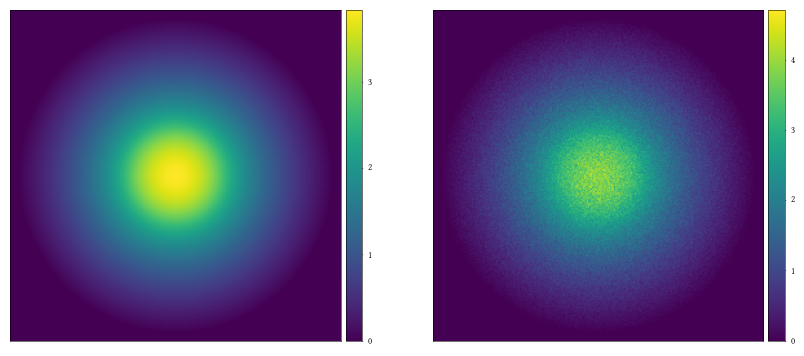

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plot_image(image_cor[0], ax1)
plot_image(image_wos[0], ax2)

Mean:
1.6673297e-05
Variance:
0.009373293


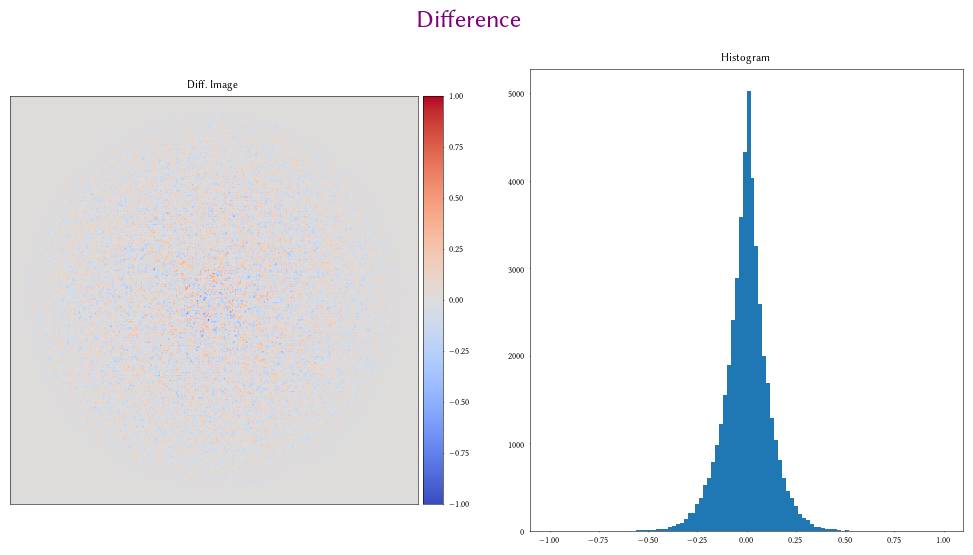

In [7]:
sketch_diff(image_cor[0], image_wos[0], max_range = 1)

In [8]:
rad_der = 0.3
res = 128
spp_der = 2 ** 20
fd_step = 5e-3
points = create_circle_points(radius = rad_der, resolution = res, spp = spp_der)
derivative_dir = points / dr.norm(points)

In [9]:
derL_v, _ = wos.solve(points_in = points, derivative_dir = derivative_dir)
der_v, _ = create_circle_from_result(derL_v, res)

0 : 134217728 -> 0


jit_flush_malloc_cache(): Dr.Jit exhausted the available memory and had to flush its allocation cache to free up additional memory. This is an expensive operation and will have a negative effect on performance. You may want to change your computation so that it uses less memory. This warning will only be displayed once.


In [13]:
derL_c = correct_radial_derivative(points,Point2f(0), source_val, source_rad, rad)
der_c, _ = create_circle_from_result(derL_c, res)

Text(0.5, 1.0, 'Radial Derivative Comparison')

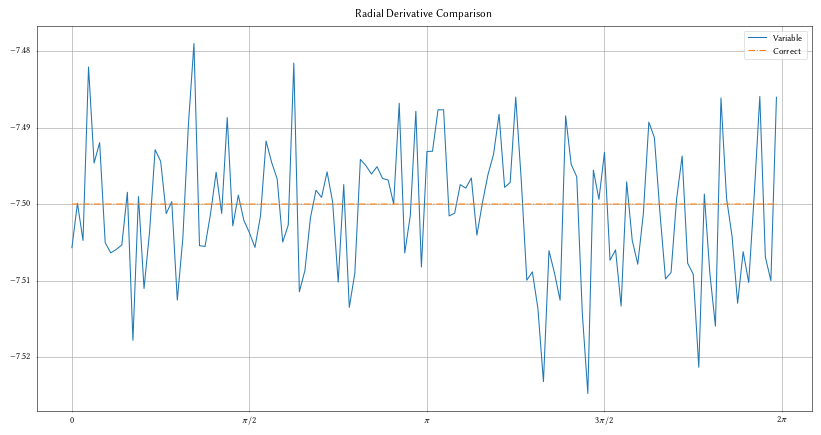

In [15]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
angle = dr.arange(Float, res).numpy() / res * 2 * dr.pi
ax.plot(angle, der_v[0], label = "Variable")
ax.plot(angle, der_c, label = "Correct", ls = '-.')
ax.legend()
_ = ax.set_xticks([0, dr.pi/2, dr.pi, 3 * dr.pi / 2, 2 * dr.pi])
_ = ax.set_xticklabels(['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
ax.grid()
ax.set_title("Radial Derivative Comparison")